## Made by Pavel Shcherbakov

In [405]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.python.summary.summary_iterator import summary_iterator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.backend import clear_session
import gc
import warnings
from keras import initializers
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('INFO')
%load_ext tensorboard
from sklearn.metrics import classification_report, confusion_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Я со звуком раньше не работал, поэтому сначала немного посмотрю на данные

In [5]:
audio_files_0 = glob(r'F:\DataScience\Educational\Job_interview\EMBLE\audio\audio\*.wav')
path_to_audio = r"F:/DataScience/Educational/Job_interview/EMBLE/audio\audio/"
print(len(audio_files_0))

2000


In [6]:
ipd.Audio(audio_files_0[0])

In [7]:
signal, sr = librosa.load(audio_files_0[10])
duration = signal.shape[0] / sr
print(f'signal shape: {signal.shape}')
print(f'sampe rate: {sr}')
print(f'the total duration of recording is {duration:.2f} sec')

signal shape: (110250,)
sampe rate: 22050
the total duration of recording is 5.00 sec


После прослушивания серии записей есть предположение, что каждую запись можно обрезать. Удостоверимся в этом, отрисовав сигнал.

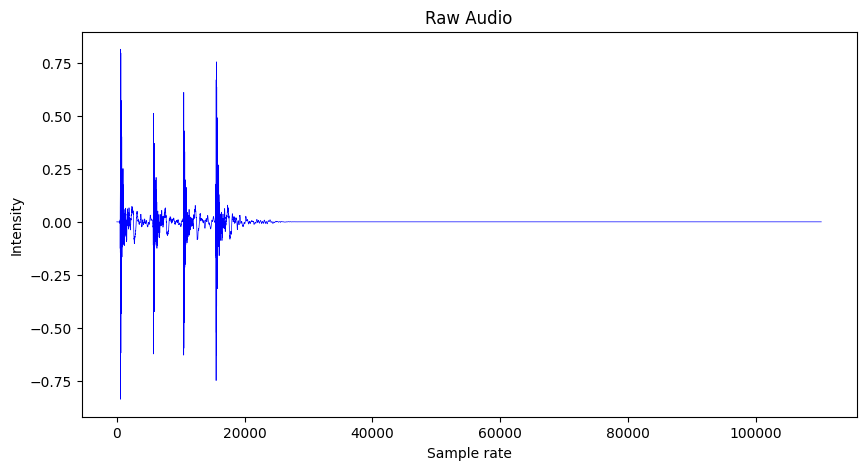

In [8]:
pd.Series(signal).plot(figsize=(10, 5), title='Raw Audio', color='blue', lw=0.5)
plt.xlabel('Sample rate')
plt.ylabel('Intensity')
plt.show()

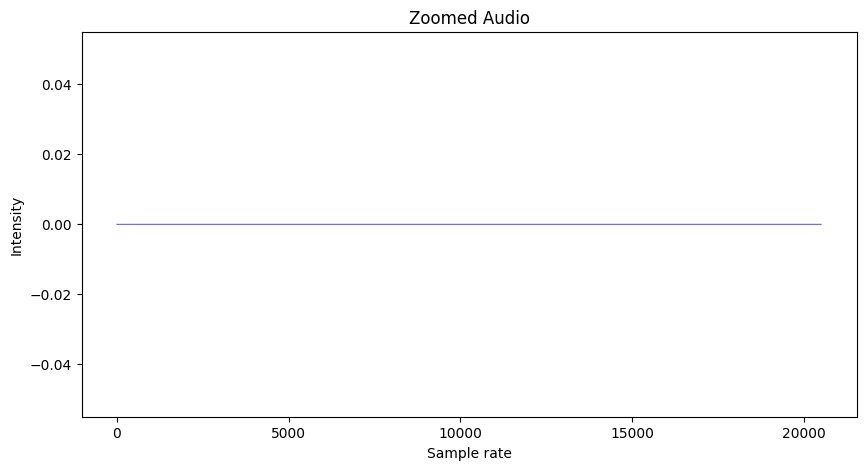

In [9]:
pd.Series(signal[40000:60500]).plot(figsize=(10, 5), title='Zoomed Audio', color='blue', lw=0.5)
plt.xlabel('Sample rate')
plt.ylabel('Intensity')
plt.show()

Как видно из зумленого графика, часть сигнала это тишина. Эту часть уж точно надо обрезать.
Когда мы обрабатываем сигнал, у нас сразу появляется вопрос, как именно обрезать, а именно, какое значение параметра top_db использовать. Кажется, что на полное решение это не должно "сильно" повлиять, поскольку наиболее значимыми являются части с большей громкостью. 

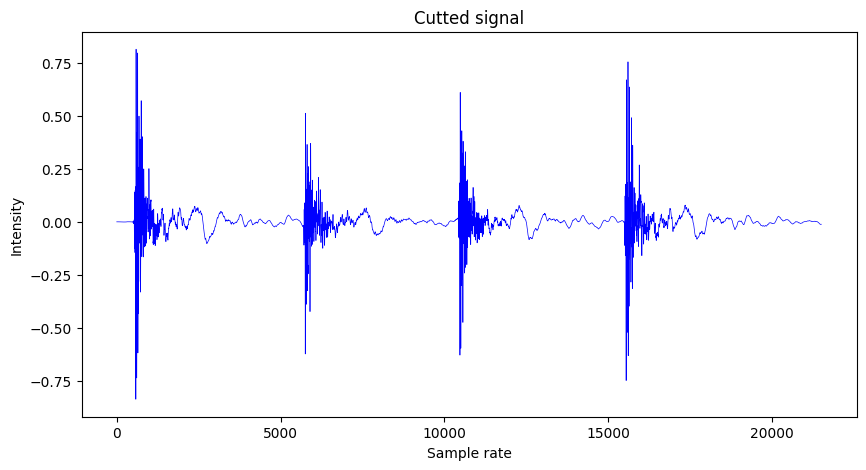

In [10]:
cutted_signal, _ = librosa.effects.trim(signal, top_db=25)
pd.Series(cutted_signal).plot(figsize=(10, 5), title='Cutted signal', color='blue', lw=0.5)
plt.xlabel('Sample rate')
plt.ylabel('Intensity')
plt.show()

In [11]:
print(f'the signal shape afrer cutting: {cutted_signal.shape}')


the signal shape afrer cutting: (21504,)


Перейдем к датасету!

In [428]:
df = pd.read_csv(r'F:\DataScience\Educational\Job_interview\EMBLE\esc50.csv')


,filename,fold,target,category,esc10,src_file,take
136,1-26143-A-21.wav,1,21,sneezing,True,26143,A
153,1-29680-A-21.wav,1,21,sneezing,True,29680,A
167,1-31748-A-21.wav,1,21,sneezing,True,31748,A
225,1-47273-A-21.wav,1,21,sneezing,True,47273,A
226,1-47274-A-21.wav,1,21,sneezing,True,47274,A
271,1-54505-A-21.wav,1,21,sneezing,True,54505,A
295,1-59324-A-21.wav,1,21,sneezing,True,59324,A
366,1-81883-A-21.wav,1,21,sneezing,True,81883,A
465,2-109505-A-21.wav,2,21,sneezing,True,109505,A
497,2-118104-A-21.wav,2,21,sneezing,True,118104,A


In [13]:
category_list = list(df['category'].unique())
len(category_list)

50

In [14]:
print(category_list, end = ' ')

['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'] 

In [15]:
#Словарь с ключем в виде названия категории и значений в виве списка файлов, относящихся к этой категории
category_dict = {}
for category in category_list:
    category_files = []
    category_files = df[df['category']==category]['filename'].to_list()
    category_dict[category] = category_files

for value in category_dict.values():
    print(len(value), end=' ')


40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 

Классы сбалансированы, теперь напишем функцию для просмотра сигнала

In [16]:
def signal_of_category(category, number):
    if 0 <= number <= len(category_dict[category]) - 1:
        file_name = category_dict[category][number]
        signal, sr = librosa.load(path_to_audio+file_name)
        pd.Series(signal).plot(figsize=(10, 5), title=f'The example {number} out of 39 from {category} category', \
                               color='blue', lw=0.5)
        plt.xlabel('Sample rate')
        plt.ylabel('Intensity')
        plt.show()
    else:
        print('The number should be between 0 and 39')
    

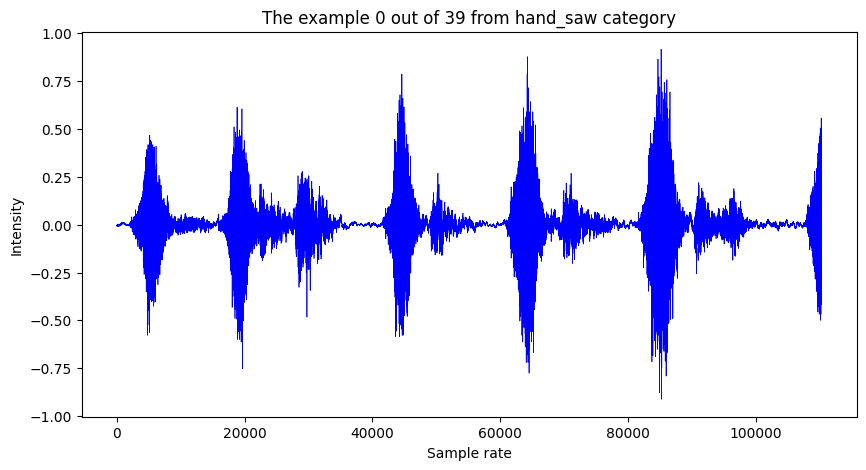

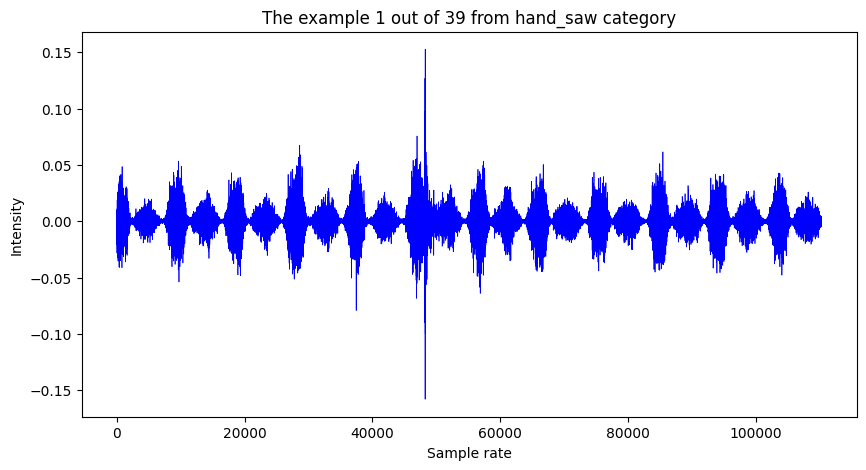

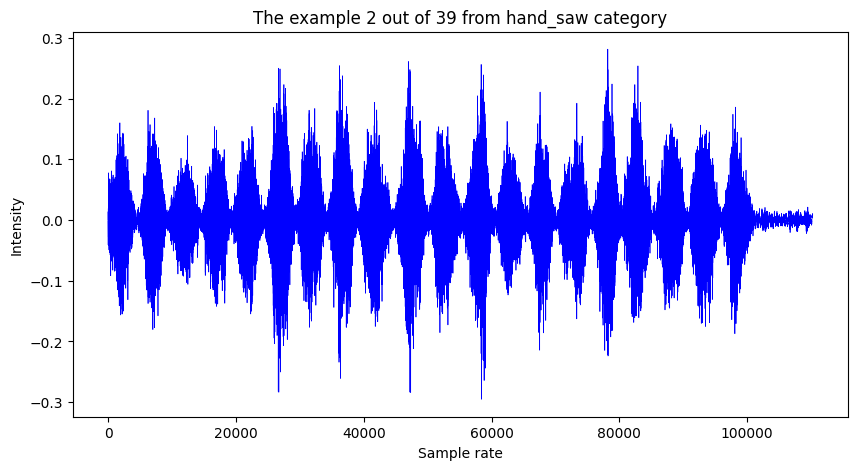

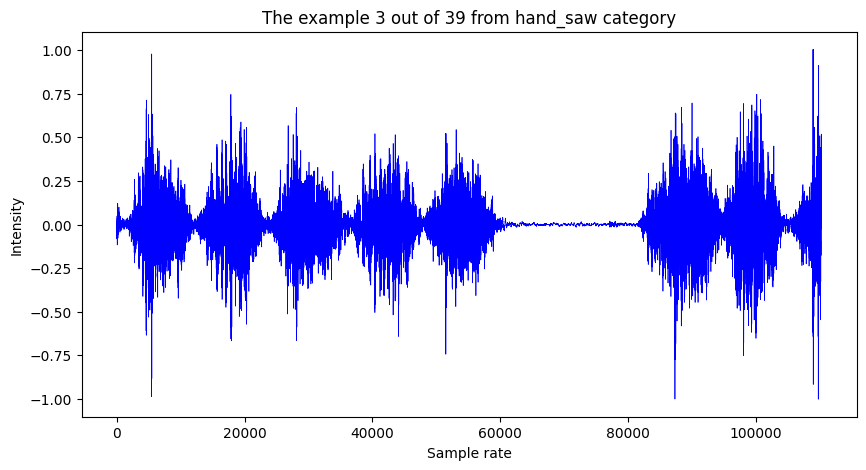

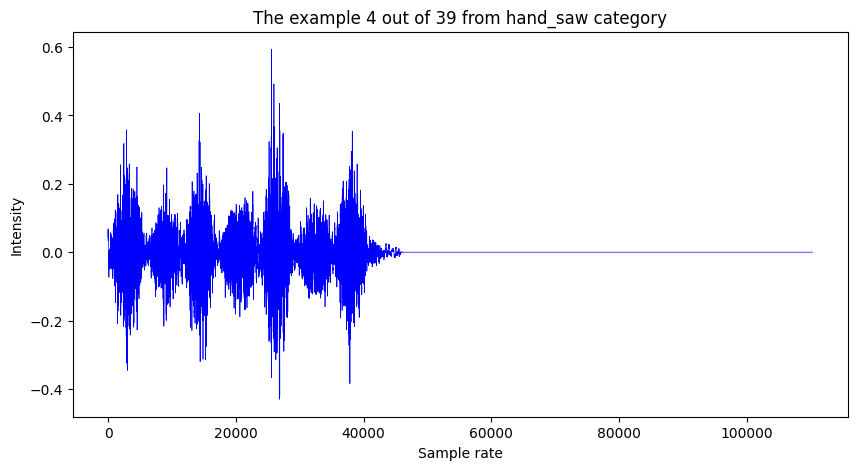

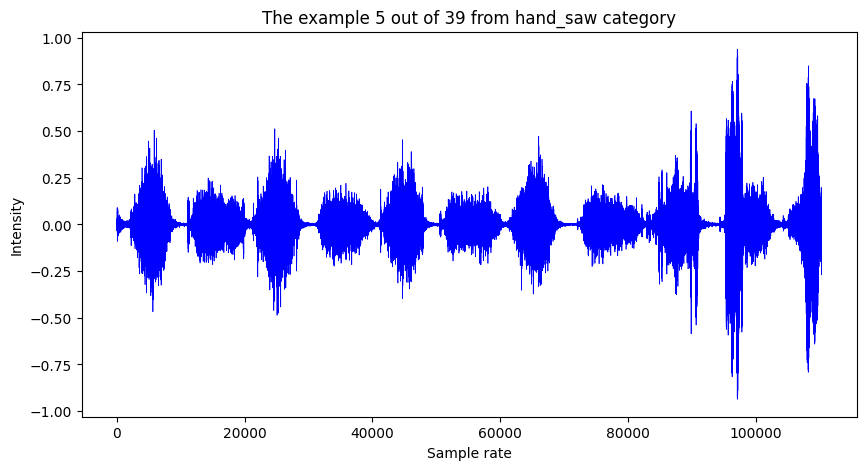

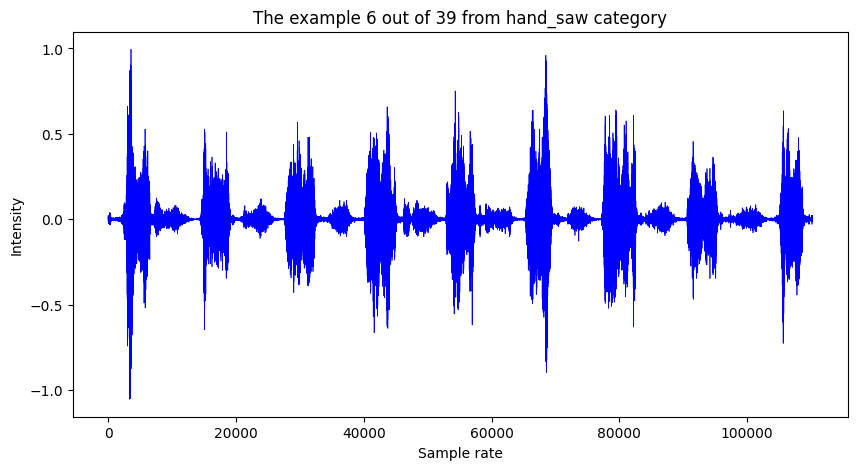

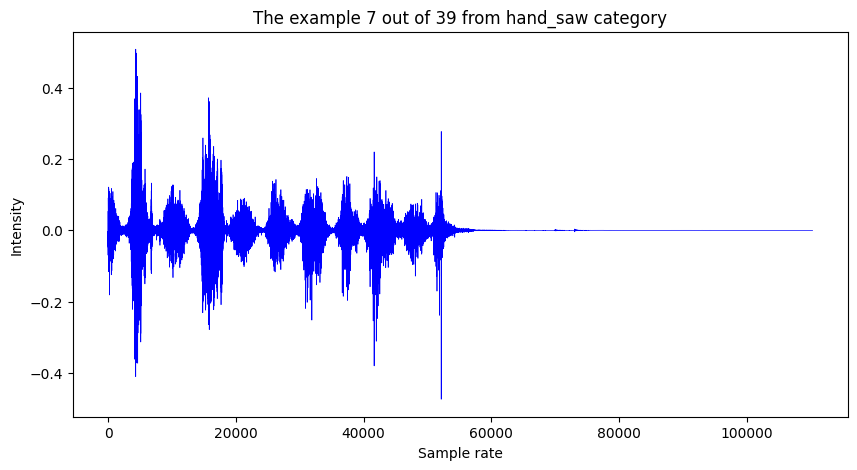

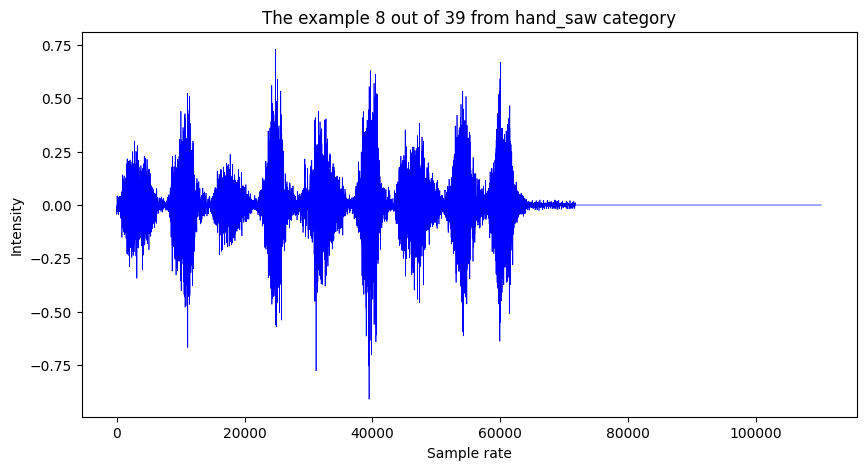

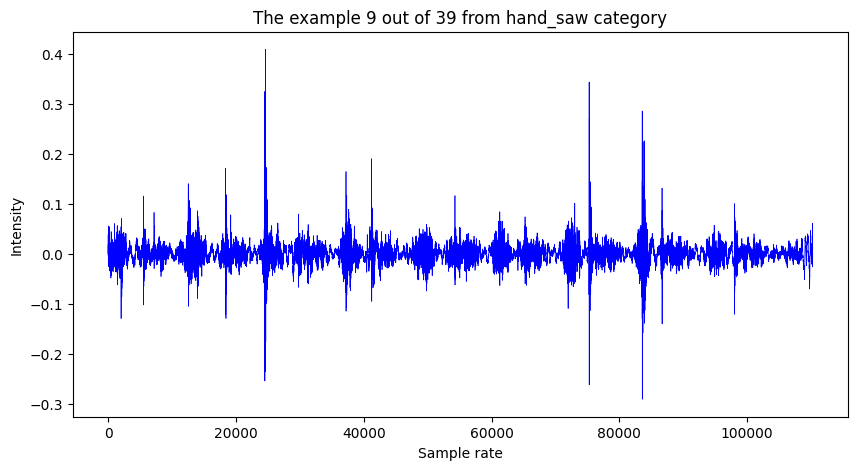

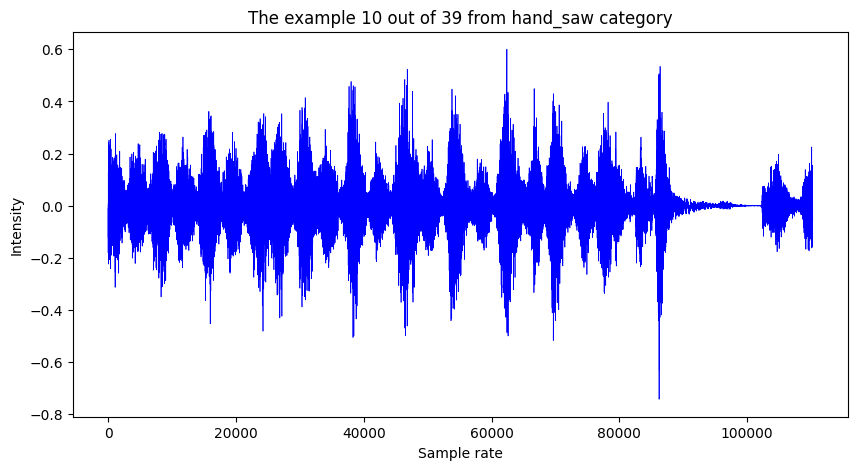

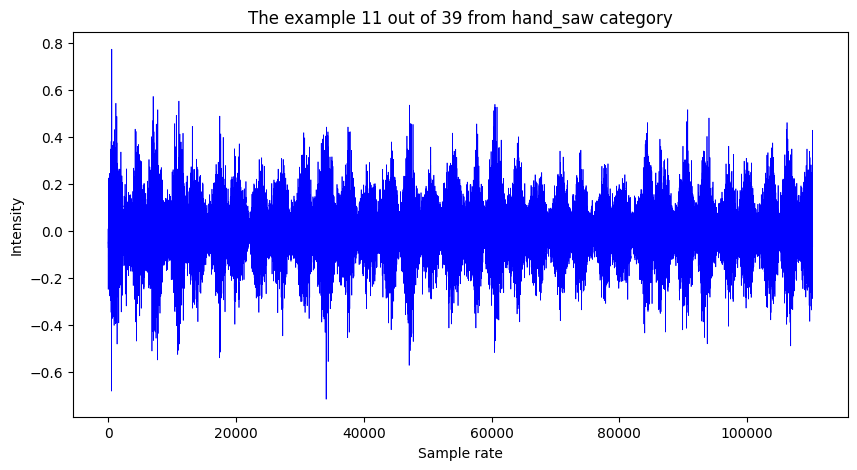

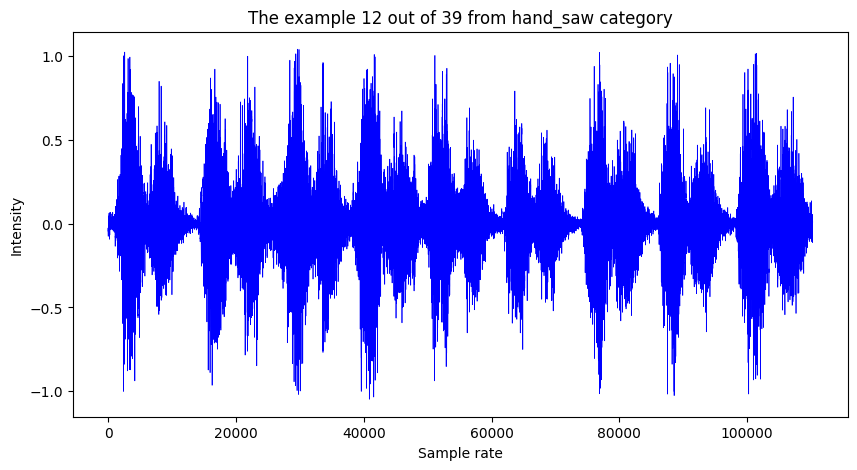

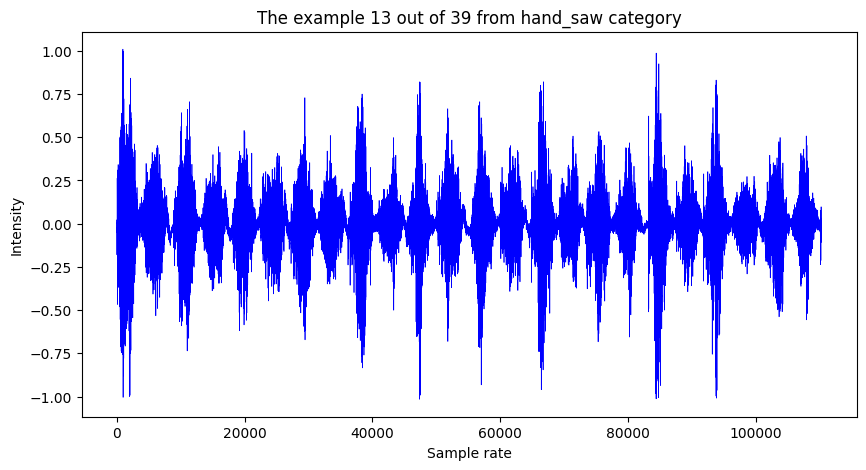

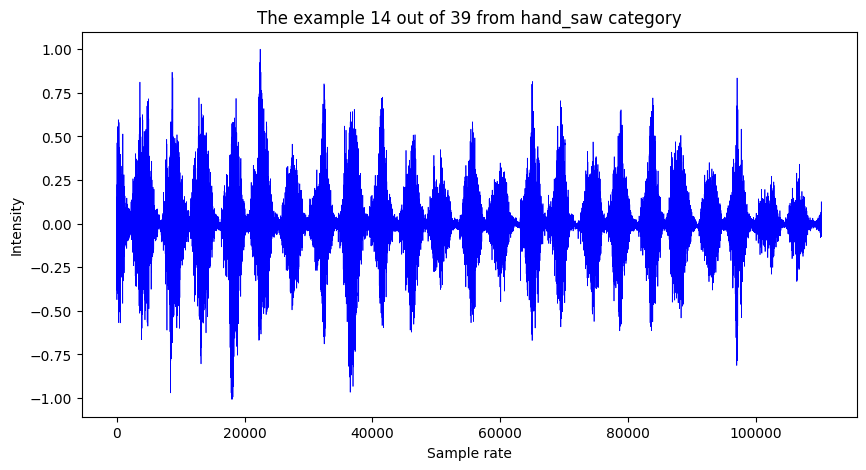

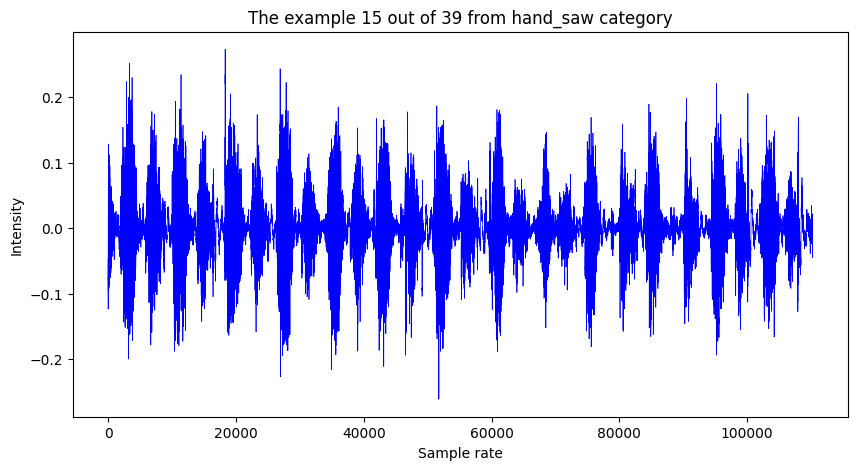

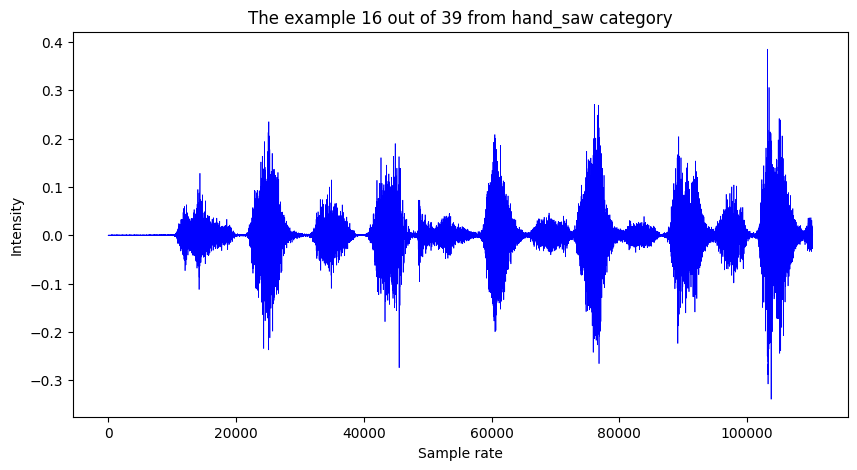

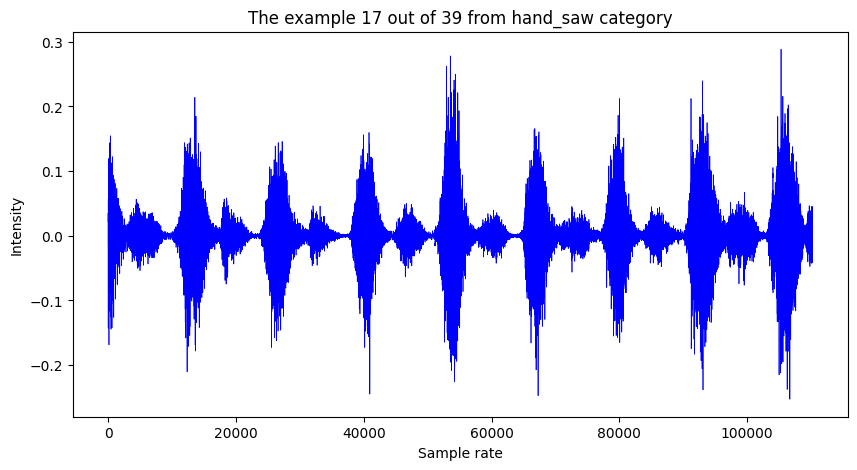

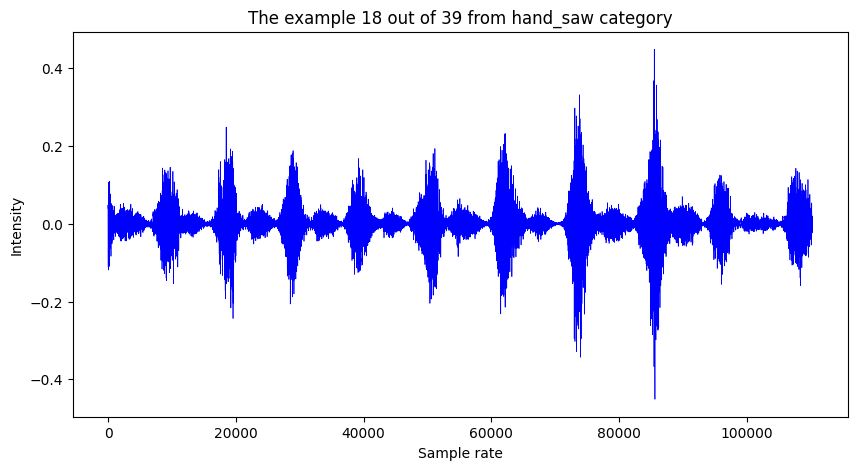

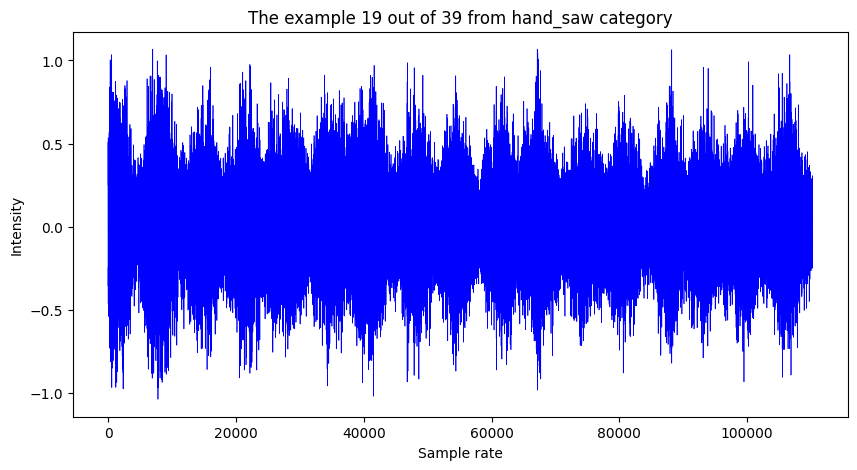

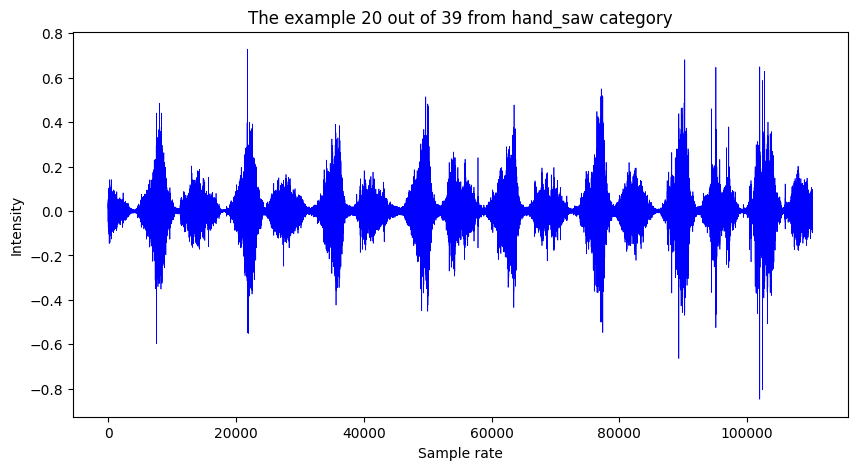

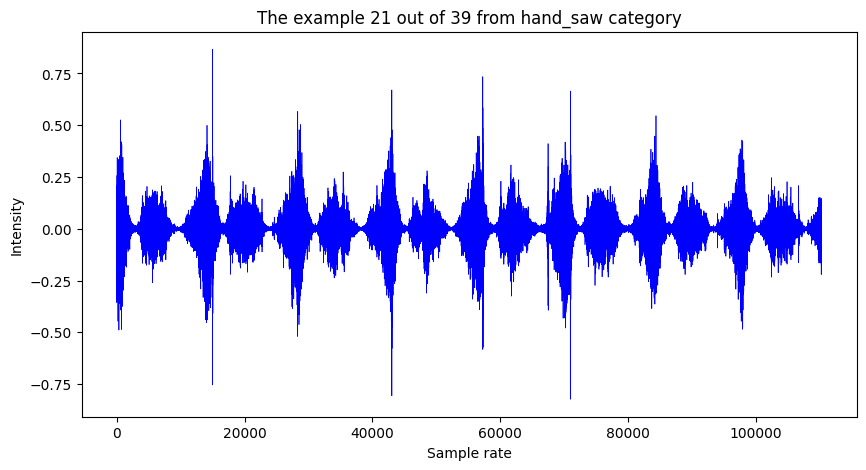

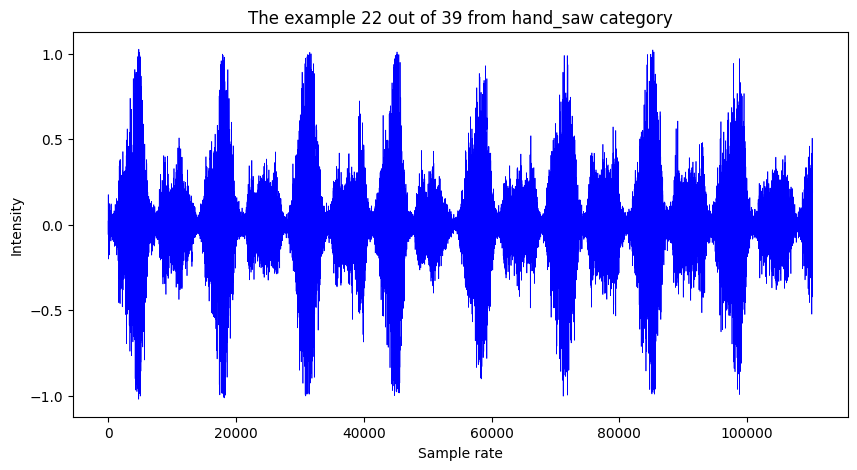

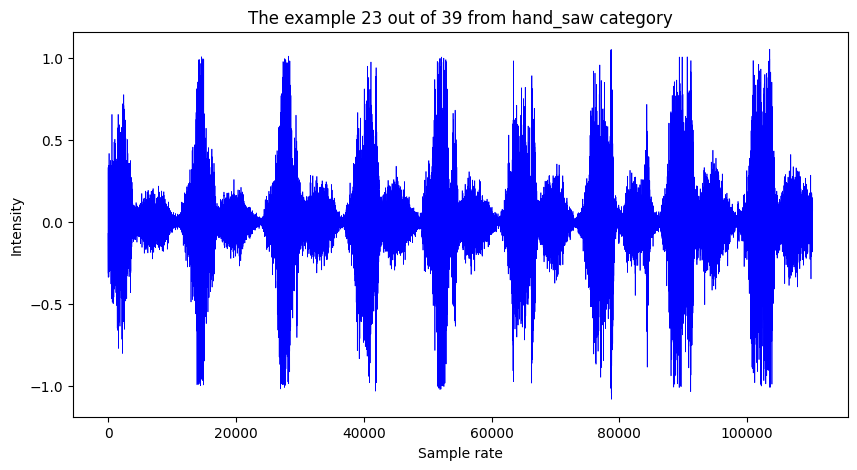

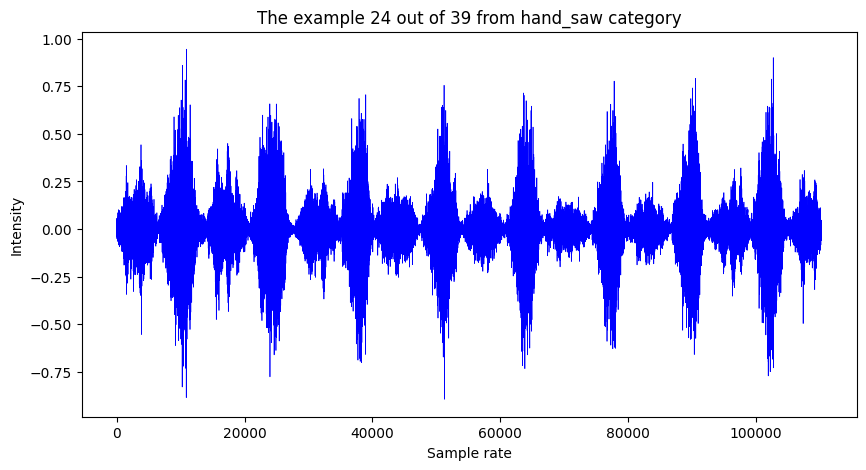

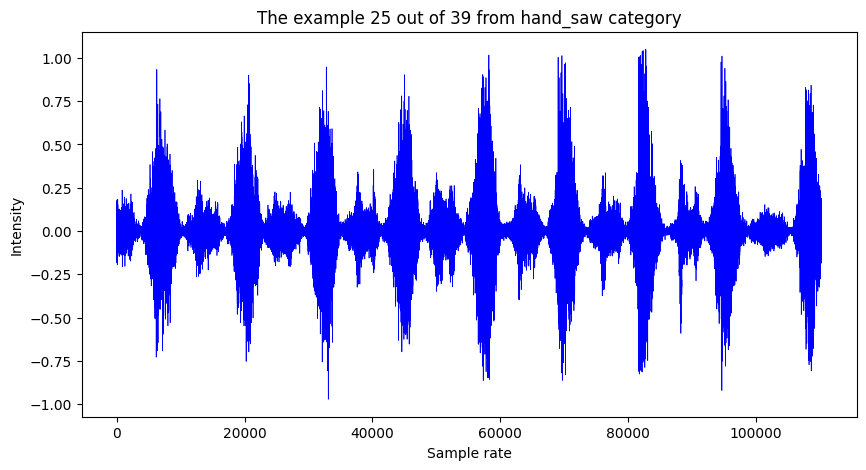

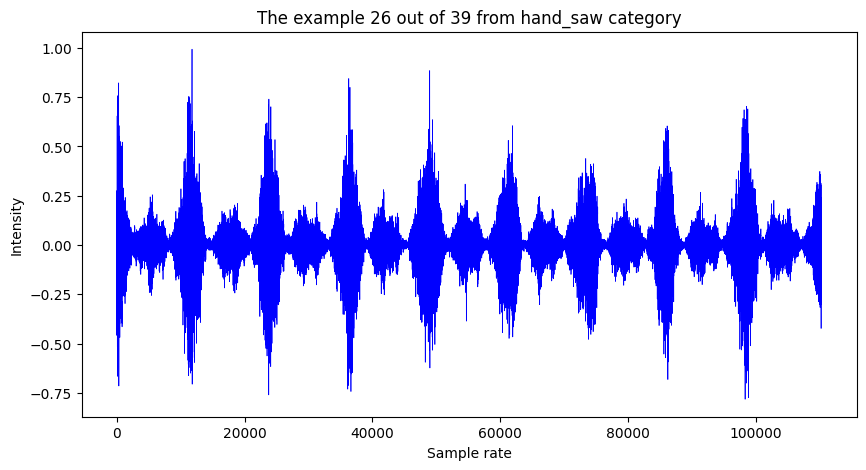

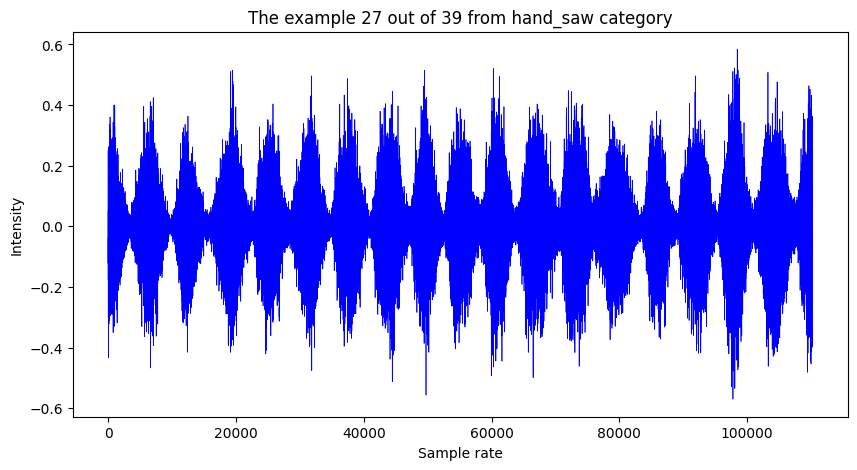

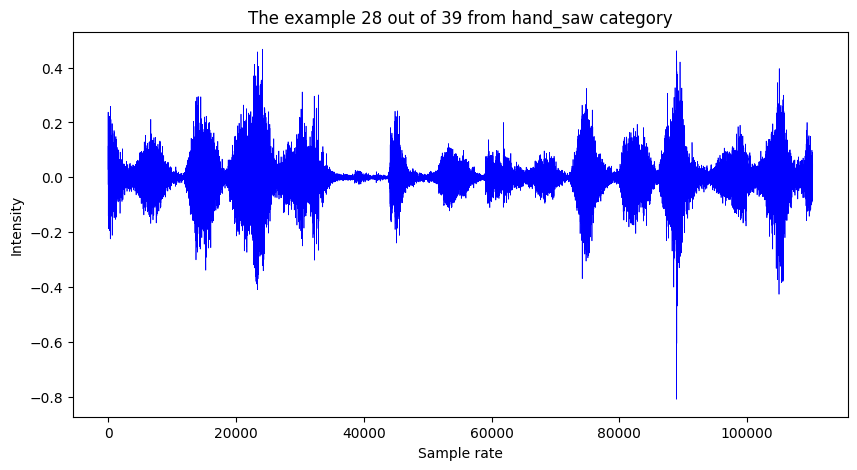

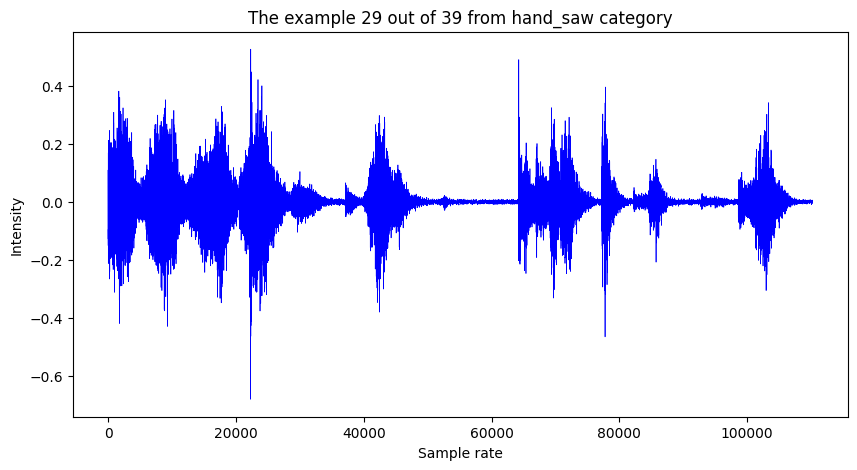

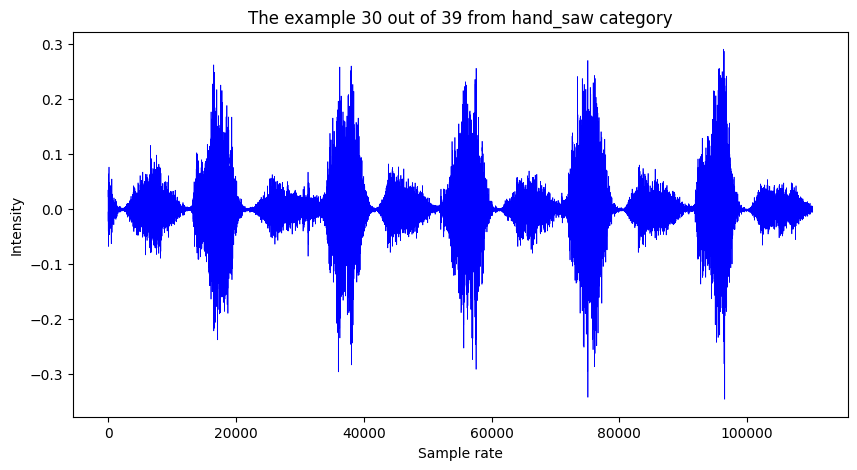

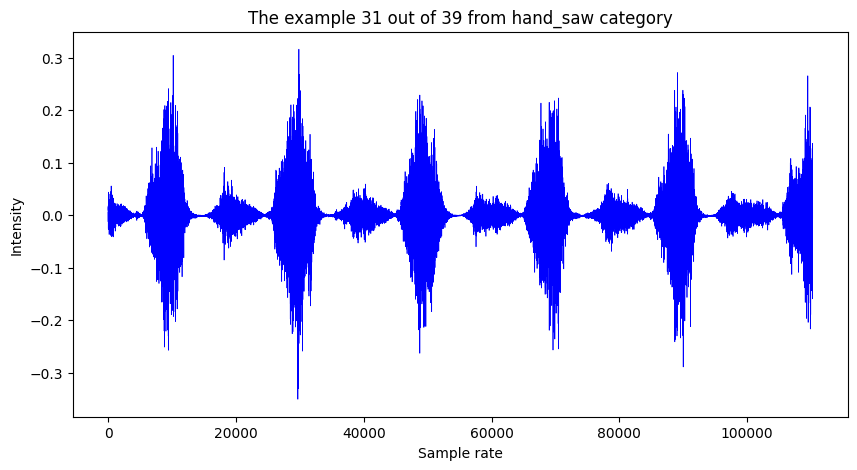

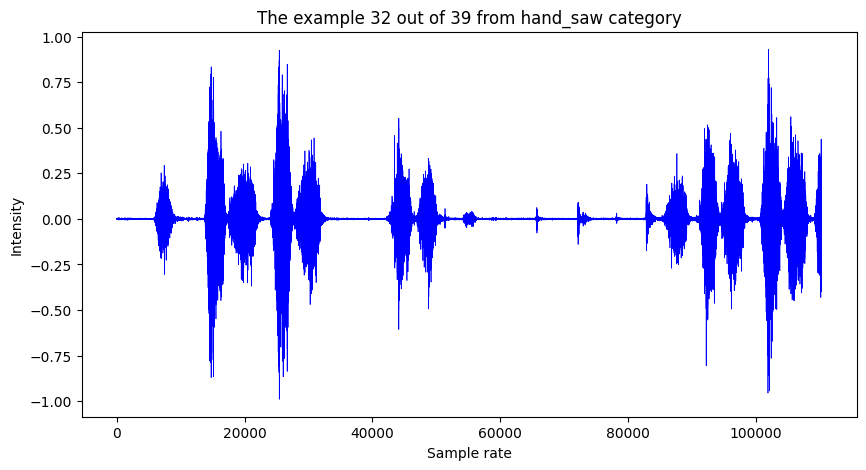

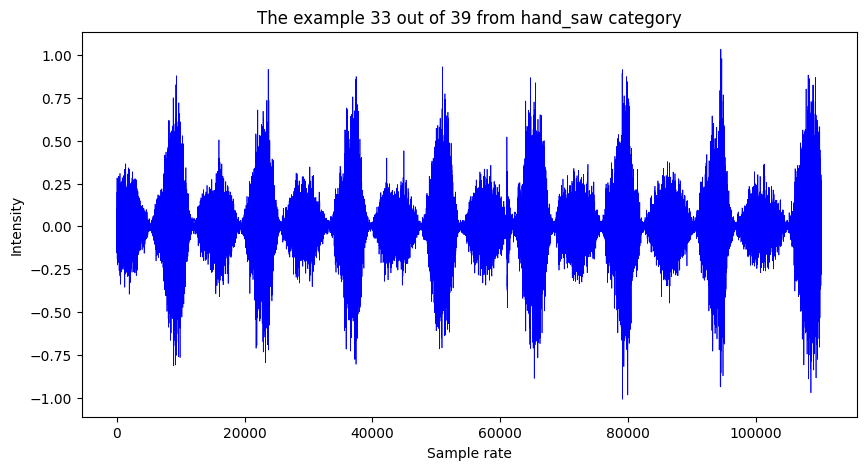

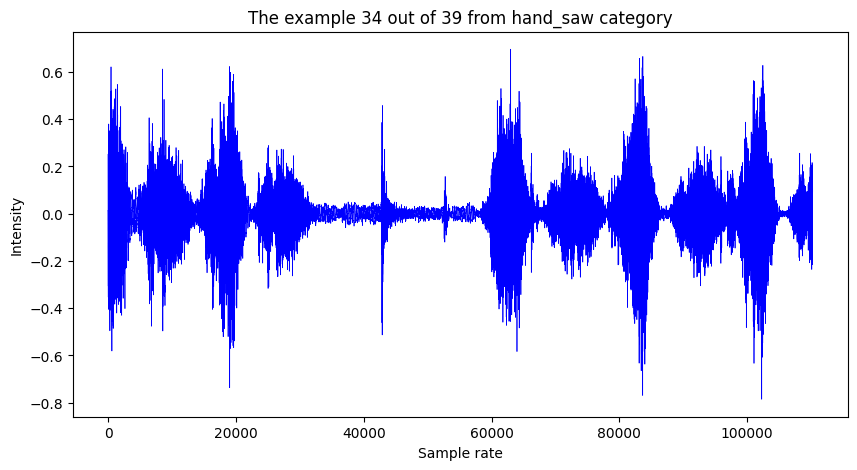

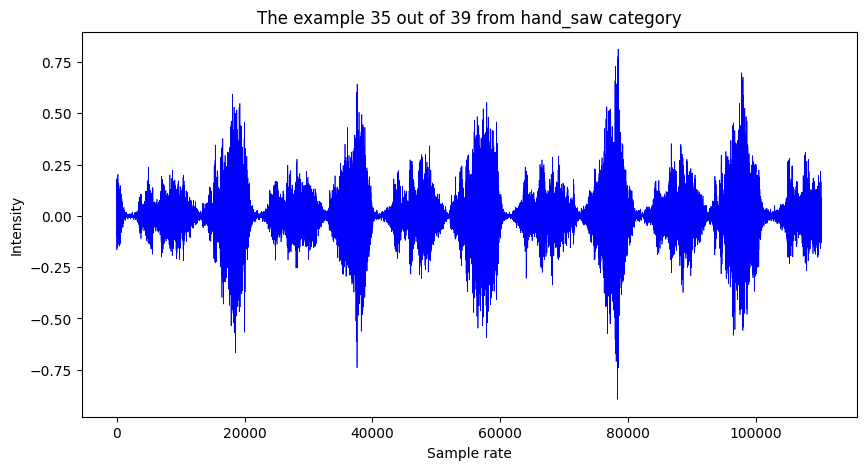

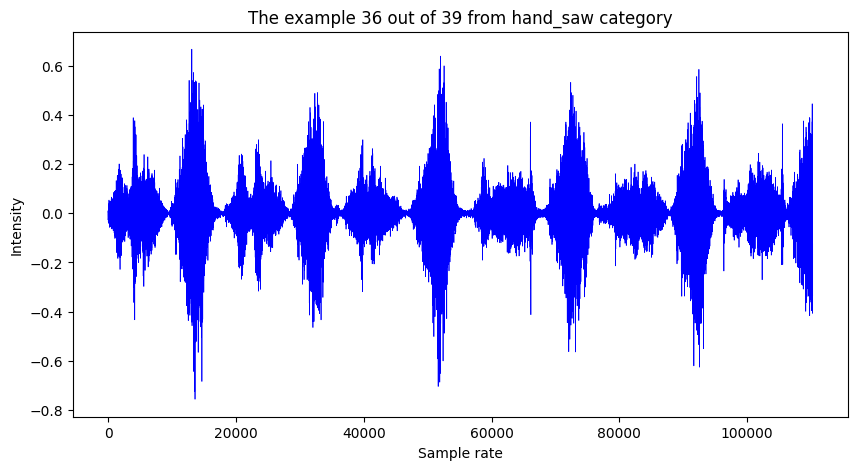

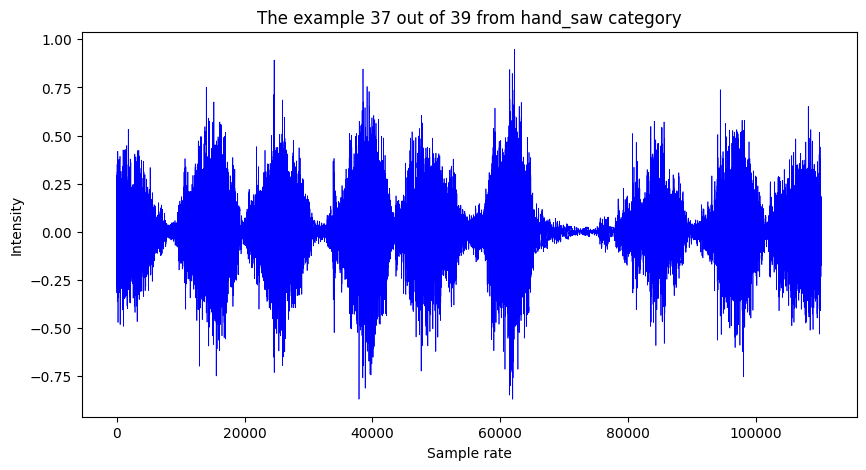

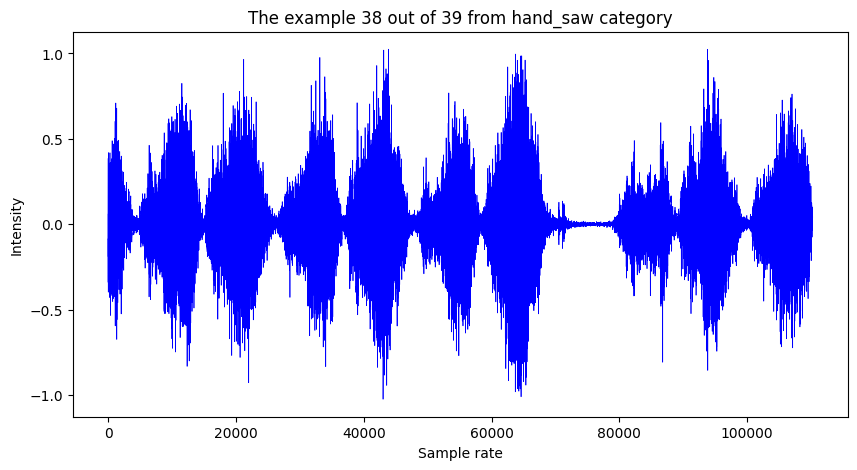

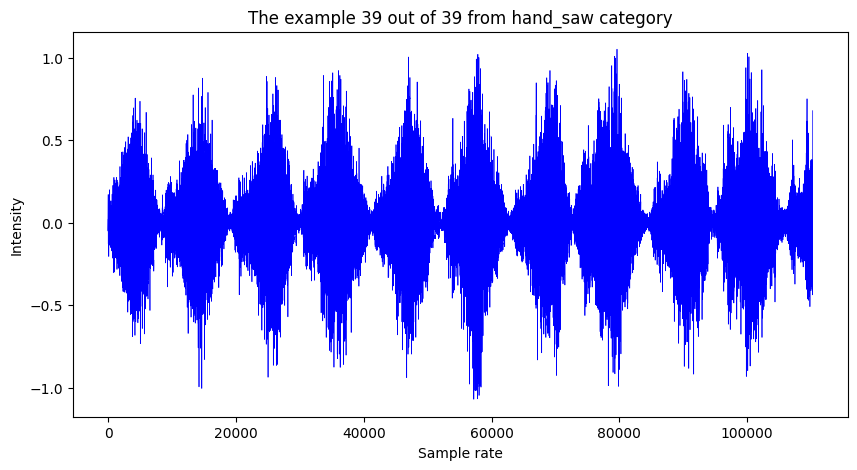

In [17]:
#Нарисуем все сигналы для какой-нибудь категории
for i in range(40):
    signal_of_category('hand_saw', i)

После отрисовки сигналов по категориям, можно сказать, что у некоторых категорий все же есть характерные особенности, которые видны даже визуально. Например, выраженная периодичность высокоамплитудных пульсаций для категории "clock_tick", отсутствие низкой интенсивности звука для категории "wind" и прочее. Сейчас уже совсем не кажется, что надо обрезать файлы, поскольку наличие "тишины" в сигнале тоже является важной компонентой, которая отделяет "отрывистые" звуки (такие как тиканье часов или лай собаки) от непрерывных (таких как работа ручной пилы 'hand_saw', например). Теперь будем генерить фичи

In [268]:
X , y = [] , []
for data in df.iterrows():
    signal, sr = librosa.load(path_to_audio + data[1][0])
    # Детально что такое mfcc спектрограмма я не стал разбираться. 
    # Пролистал этот видос https://www.youtube.com/watch?v=4_SH2nfbQZ8 
    # И решил что feature.mfcc выделяет что-то типа первых 13 слагаемых ряда фурье. 
    # Самое главное что данная процедура выделяет наиболее важные характрестики сигнала,
    # значительно сокращая размерность задачи
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    X.append(mfcc)
    # Добавляет метку класса
    y.append(data[1][2])
X = np.array(X) 
y = np.array(y)
y = utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


В качестве базовой модели возьмем сверточную нейронную сеть. Предобученные модели не трогаю.

In [269]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=10)


In [186]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [20]:
X_train.shape

(1500, 13, 216, 1)

Откладывая для теста 500 записей, по 10 в каждом из 50 классов, точность на тестовых экземплярах сильно зависит от выборки. 
Предлагаю для отладки изменения параметров модели использовать 5 фолдов. А к отложенной выборке (X_test, Y_test) вернуться после настройки параметров модели.

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [22]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [399]:
def plot_hist():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [175]:
# Усреднение списка
def calc_mean(array):
    return np.array(array).mean()


In [299]:
# Функция для создания модели, архитектура нейросети будет состоять из блоков. 
def create_model(num_of_blocks, kernel_size = (3,3), activation = 'relu', num_of_params_before_softmax=200,
                conv_params = 64, dropout_rate = 0.25, learning_rate = 0.001):
    input_shape = (X_train.shape[1],X_train.shape[2],1)
    model = Sequential()
    for i in range(1, num_of_blocks + 1):
        if i == 1:
            model.add(Conv2D(conv_params, kernel_size=kernel_size, activation=activation,
                             input_shape=input_shape, padding='same'))
            model.add(Conv2D(conv_params, kernel_size=kernel_size, activation=activation, padding='same'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))
        else:
            model.add(Conv2D(conv_params, kernel_size=kernel_size, activation=activation, padding='same'))
            model.add(Conv2D(conv_params, kernel_size=kernel_size, activation=activation, padding='same'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_of_params_before_softmax, activation = 'relu'))
    model.add(Dense(50, activation = 'softmax'))
    opt = Adam(learning_rate=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = 'acc')
    model.save_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')
    return model

In [273]:
model = create_model(1, learning_rate = 0.06)

In [281]:
# Сохранение в тензорбоард
check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Ранняя остановка чтобы не переобучаться
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=30, verbose=0, mode='auto',
baseline=None, restore_best_weights=False)

kfold = KFold(n_splits=5, random_state=10, shuffle=True)

#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
          
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=96,
                        callbacks = [check_log, es], epochs=500, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=32)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
        
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

train_loss:1.3924244403839112, train_acc:0.615500009059906, val_loss:2.0384685516357424, val_a:0.4273333251476288


### Снизу будет телега текста, но она важна.

Сначала я хотел менять архитектуру нейросети, используя кросс-валидацию с пятью фолдами. В этом случае обучение происходит на 1200 экземплярах, а валидация на 300 (по 6 экземпляров каждого класса, получается что правильное предсказание конкретного экземпляра "стоит" 0.33%). Полученные результаты усреднял. Запуская такие расчеты с одними и теми же параметрами(веса модели фиксированы, все возможные сиды тоже фиксированы) я получал результаты, которые отличались друг от друга, например, на 10% по точности (что соответствует разнице в 36 неверно предсказанных классах экземпляров). На этом я не остановился (хотя, очевидно, стоило) и решил провести пять раз пятифолдовую кросс-валидацию и результаты усреднить. Результат оказался примерно тем же. 

В такой ситуации нельзя менять параметры и смотреть какой параметр лучше / хуже. Мне кажется, что такой результат связан с двумя вещами. Первая, это, конечно, недостаток выборки. А вторая это работа SGD (который я потом сменил на Adam и сходимость сразу улучшилась), который, видимо, каждый раз при вычислении псевдоградиента брал рандомные сэмплы из батча, которые влияли на то, в какую сторону двигаться. И если несколько раз подряд мы шагнули в неудачную сторону, то алгоритм остановливался при помощи early stopping. Чтобы с этим побороться, я пробовал увеличивать шаг обучения а также в early stopping увеличивал patience, но это тоже не помогало. Кароче, данных не хватает, буду генерить новые, возникла идея нарезать каждый файл на фрагменты.

In [283]:
X, y = [], []
for data in df.iterrows():
    signal, sr = librosa.load(path_to_audio + data[1][0])
    signal = np.concatenate((signal,signal),axis=None) 
    m, l = [], []
    step = 11025
    start = 0
    end = start + step - 1
    for i in range(20): # Разобьем каждый клип на отрезки по 0.5 секунды
        signal_cut = signal[start:end]
        start += step
        end += step
        melspec = librosa.feature.melspectrogram(signal_cut, n_mels = 39) # В этот раз возьмем в три раза больше
        X.append(melspec)
    # Добавляет метку класса
        y.append(data[1][2])
X = np.array(X) 
y = np.array(y)
y = utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


In [284]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train.shape


(32000, 39, 22, 1)

Теперь у нас гораздо больше данных, ура! Первым параметром поварьируем количество блоков (свертка + свертка + макспуллинг + нормализация весов + дропаут слой, чтобы не переобучаться). Во всех рассчетах будем проводить пятифолдовую кросс-валидацию и результаты по всем фолдам усреднять. В исходном датасете были номера фолдов, но я их не использовал.

In [300]:
model = create_model(1)

In [301]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models/1_block"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\1_block/test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1

Epoch 1: val_acc improved from -inf to 0.06437, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 2: val_acc did not improve from 0.06437

Epoch 3: val_acc improved from 0.06437 to 0.09094, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 4: val_acc improved from 0.09094 to 0.10406, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 5: val_acc improved from 0.10406 to 0.15000, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 6: val_acc improved from 0.15000 to 0.15500, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 7: val_acc improved from 0.15500 to 0.21109, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_1.h5

Epoch 8: val_acc improved from 0.21109 to 0.29141, saving model to F:\DataScience\Educational\Job_inter


Epoch 6: val_acc improved from 0.11312 to 0.14922, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 7: val_acc improved from 0.14922 to 0.20594, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 8: val_acc improved from 0.20594 to 0.24094, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 9: val_acc improved from 0.24094 to 0.25453, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 10: val_acc improved from 0.25453 to 0.28219, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 11: val_acc improved from 0.28219 to 0.35203, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_2.h5

Epoch 12: val_acc did not improve from 0.35203

Epoch 13: val_acc improved from 0.35203 to 0.37750, saving model to F:\DataScience\Educational\Job_interview\EMBLE\


Epoch 6: val_acc improved from 0.14859 to 0.17500, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 7: val_acc improved from 0.17500 to 0.20328, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 8: val_acc improved from 0.20328 to 0.23625, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 9: val_acc improved from 0.23625 to 0.27109, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 10: val_acc improved from 0.27109 to 0.27734, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 11: val_acc improved from 0.27734 to 0.30469, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_3.h5

Epoch 12: val_acc did not improve from 0.30469

Epoch 13: val_acc improved from 0.30469 to 0.34406, saving model to F:\DataScience\Educational\Job_interview\EMBLE\


Epoch 6: val_acc improved from 0.11844 to 0.12391, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 7: val_acc improved from 0.12391 to 0.15422, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 8: val_acc improved from 0.15422 to 0.21906, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 9: val_acc improved from 0.21906 to 0.25609, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 10: val_acc improved from 0.25609 to 0.26828, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 11: val_acc improved from 0.26828 to 0.30844, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_4.h5

Epoch 12: val_acc did not improve from 0.30844

Epoch 13: val_acc did not improve from 0.30844

Epoch 14: val_acc improved from 0.30844 to 0.32891, saving model to


Epoch 4: val_acc improved from 0.08313 to 0.09953, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 5: val_acc did not improve from 0.09953

Epoch 6: val_acc improved from 0.09953 to 0.12156, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 7: val_acc improved from 0.12156 to 0.14797, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 8: val_acc improved from 0.14797 to 0.17141, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 9: val_acc improved from 0.17141 to 0.18844, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 10: val_acc improved from 0.18844 to 0.23937, saving model to F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\model_5.h5

Epoch 11: val_acc did not improve from 0.23937

Epoch 12: val_acc improved from 0.23937 to 0.31297, saving model to F

In [365]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 1 fold with val_acc 0.678906261920929


In [328]:
model.load_weights(r'F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/model_1.h5')

In [329]:
model.evaluate(X_test, Y_test)
y_pred = model.predict(X_test)

250/250 [==============================] - 1s 3ms/step - loss: 1.1836 - acc: 0.6712


[1.1835664510726929, 0.6712499856948853]

Модель с одним блоком достигла точности 67.12% на отложенной тестовой выборке, что близко к результаты на валидационной, это хорошо. К тестовой выборке мы обращаться больше не будем до самого конца. Все параметры настраиваем только по валидационной выборке. Посмотрим на модель с двумя блоками:

In [367]:
model = create_model(2)

In [369]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/2_layers/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.59346524477005, train_acc:0.8266093730926514, val_loss:0.774144959449768, val_a:0.7907187581062317


In [370]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 1 fold with val_acc 0.8023437261581421


И с тремя!

In [371]:
model = create_model(3)

In [372]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.5467630505561829, train_acc:0.8394921898841858, val_loss:0.6985926985740661, val_a:0.8134687423706055


In [373]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 1 fold with val_acc 0.8165624737739563


Дальше идти не будем, остановимся на трёх блоках, здесь самая высокая точность. Поварьируем количество сверточных фильтров, с дефолтных 64 на 32.

In [375]:
model = create_model(3, conv_params=32)

In [376]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.9221112966537476, train_acc:0.7254531264305115, val_loss:0.9615381717681885, val_a:0.7291249990463257


In [377]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 4 fold with val_acc 0.7360937595367432


Точность уменьшилась. Поставим 128

In [378]:
model = create_model(3, conv_params=128)

In [379]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.38932270407676695, train_acc:0.8869218707084656, val_loss:0.6440104365348815, val_a:0.8426250100135804


In [380]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 2 fold with val_acc 0.8479687571525574


Со 128 сверточными параметрами удалось прибавить, попробуем задать размер ядра 5х5

In [389]:
model = create_model(3, conv_params=128, kernel_size=(5,5))

In [390]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.3598117530345917, train_acc:0.8962031364440918, val_loss:0.6707253336906434, val_a:0.8459374904632568


In [391]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 2 fold with val_acc 0.8529687523841858


Точность улучшилась, попробуем дропаут увеличить до 0.5, может меньше будем переобучаться

In [392]:
model = create_model(3, conv_params=128, kernel_size=(5,5), dropout_rate=0.5)

In [393]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/Dropout=0.5/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.4226379215717316, train_acc:0.876687490940094, val_loss:0.6172365665435791, val_a:0.8490000009536743


In [394]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 1 fold with val_acc 0.8539062738418579


Для лучшей модели прибавили 0.1% в точности, в среднем прибавили 0.3%! Разница между точностью на обучающей и валидационной выборкой уменьшилась. Теперь увеличим количество линейных параметров перед софтмакс слоем:

In [395]:
model = create_model(3, conv_params=128, kernel_size=(5,5), dropout_rate=0.5,
                     num_of_params_before_softmax = 512)

In [397]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/Dropout=0.5/Before_softmax/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit(X_train[train_index], Y_train[train_index], batch_size=256,
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        validation_data=(X_train[val_index], Y_train[val_index]),
                        validation_batch_size=128)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.41808921098709106, train_acc:0.8785703182220459, val_loss:0.6077188849449158, val_a:0.8488437533378601


In [398]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 1 fold with val_acc 0.8568750023841858


В среднем вариант с 512 параметрами чуть уступает предыдущей версии с 200 параметрами, но модель, обучавшаяся на первом фолде, на 0.3% прибавила в точности. Попробуем применить ещё аугментацию для данных.

In [401]:
model = create_model(3, conv_params=128, kernel_size=(5,5), dropout_rate=0.5,
                     num_of_params_before_softmax = 200)

In [403]:
datagen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15, horizontal_flip=True,  
              vertical_flip=True)

In [411]:
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
fold = 1
#for i in range(5):
train_loss, train_acc, val_acc, val_loss, = [], [], [], []
for train_index, val_index in kfold.split(X_train, Y_train):
    # Сохранение в тензорбоард
    check_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
    # Ранняя остановка чтобы не переобучаться
    #es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    #                                  baseline=None, restore_best_weights=True)
    # Сохраним веса моделей, обученных на фолдах
    model_path = r"F:/DataScience/Educational/Job_interview/EMBLE/ESC50/models/3_layers/conv_param/Dropout=0.5/Before_softmax/"+get_model_name(fold)
    model_save = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc',
                                             verbose=0, save_best_only=True, mode='max')
    
    print(f"Current fold is {fold}")      
    history = model.fit_generator(datagen.flow(X_train[train_index], Y_train[train_index], batch_size=256),
                        callbacks = [check_log, model_save], epochs=100, verbose=0,
                        steps_per_epoch =100,
                        validation_data=datagen.flow(X_train[val_index], Y_train[val_index]),
                        validation_steps=50)
        
    train_loss.append(np.array(history.history['loss']).min())
    train_acc.append(np.array(history.history['acc']).max())
    val_loss.append(np.array(history.history['val_loss']).min())
    val_acc.append(np.array(history.history['val_acc']).max())
    
    model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\model_weights\test.h5')    
    fold += 1
    # Усреднение полученных показателей
tr_l, tr_a, val_l, val_a = calc_mean(train_loss), calc_mean(train_acc), calc_mean(val_loss), calc_mean(val_acc)
print(f'Mean indicators overall train_loss:{tr_l}, train_acc:{tr_a}, val_loss:{val_l}, val_a:{val_a}')    

Current fold is 1
Current fold is 2
Current fold is 3
Current fold is 4
Current fold is 5
Mean indicators overall train_loss:0.9667865037918091, train_acc:0.712039053440094, val_loss:0.9646828770637512, val_a:0.721625006198883


In [412]:
best_fold = np.argmax(val_acc) + 1
print(f'The best model corresponds to {best_fold} fold with val_acc {val_acc[best_fold - 1]}')

The best model corresponds to 3 fold with val_acc 0.7381250262260437


 Аугментация в данном случае не помогла (возможно, не стоило включать вертикальный флип). Загрузим лучшую модель и посчитаем тестовую выборку.

In [418]:
model.load_weights(r'F:\DataScience\Educational\Job_interview\EMBLE\ESC50\models\3_layers\conv_param\Dropout=0.5/model_1.h5')

In [430]:
model.evaluate(X_test, Y_test)

250/250 [==============================] - 2s 9ms/step - loss: 0.6181 - acc: 0.8489


[0.6181468963623047, 0.8488749861717224]

Точность 84.9%.

In [422]:
y_pred = model.predict(X_test)

250/250 [==============================] - 2s 8ms/step


<AxesSubplot:>

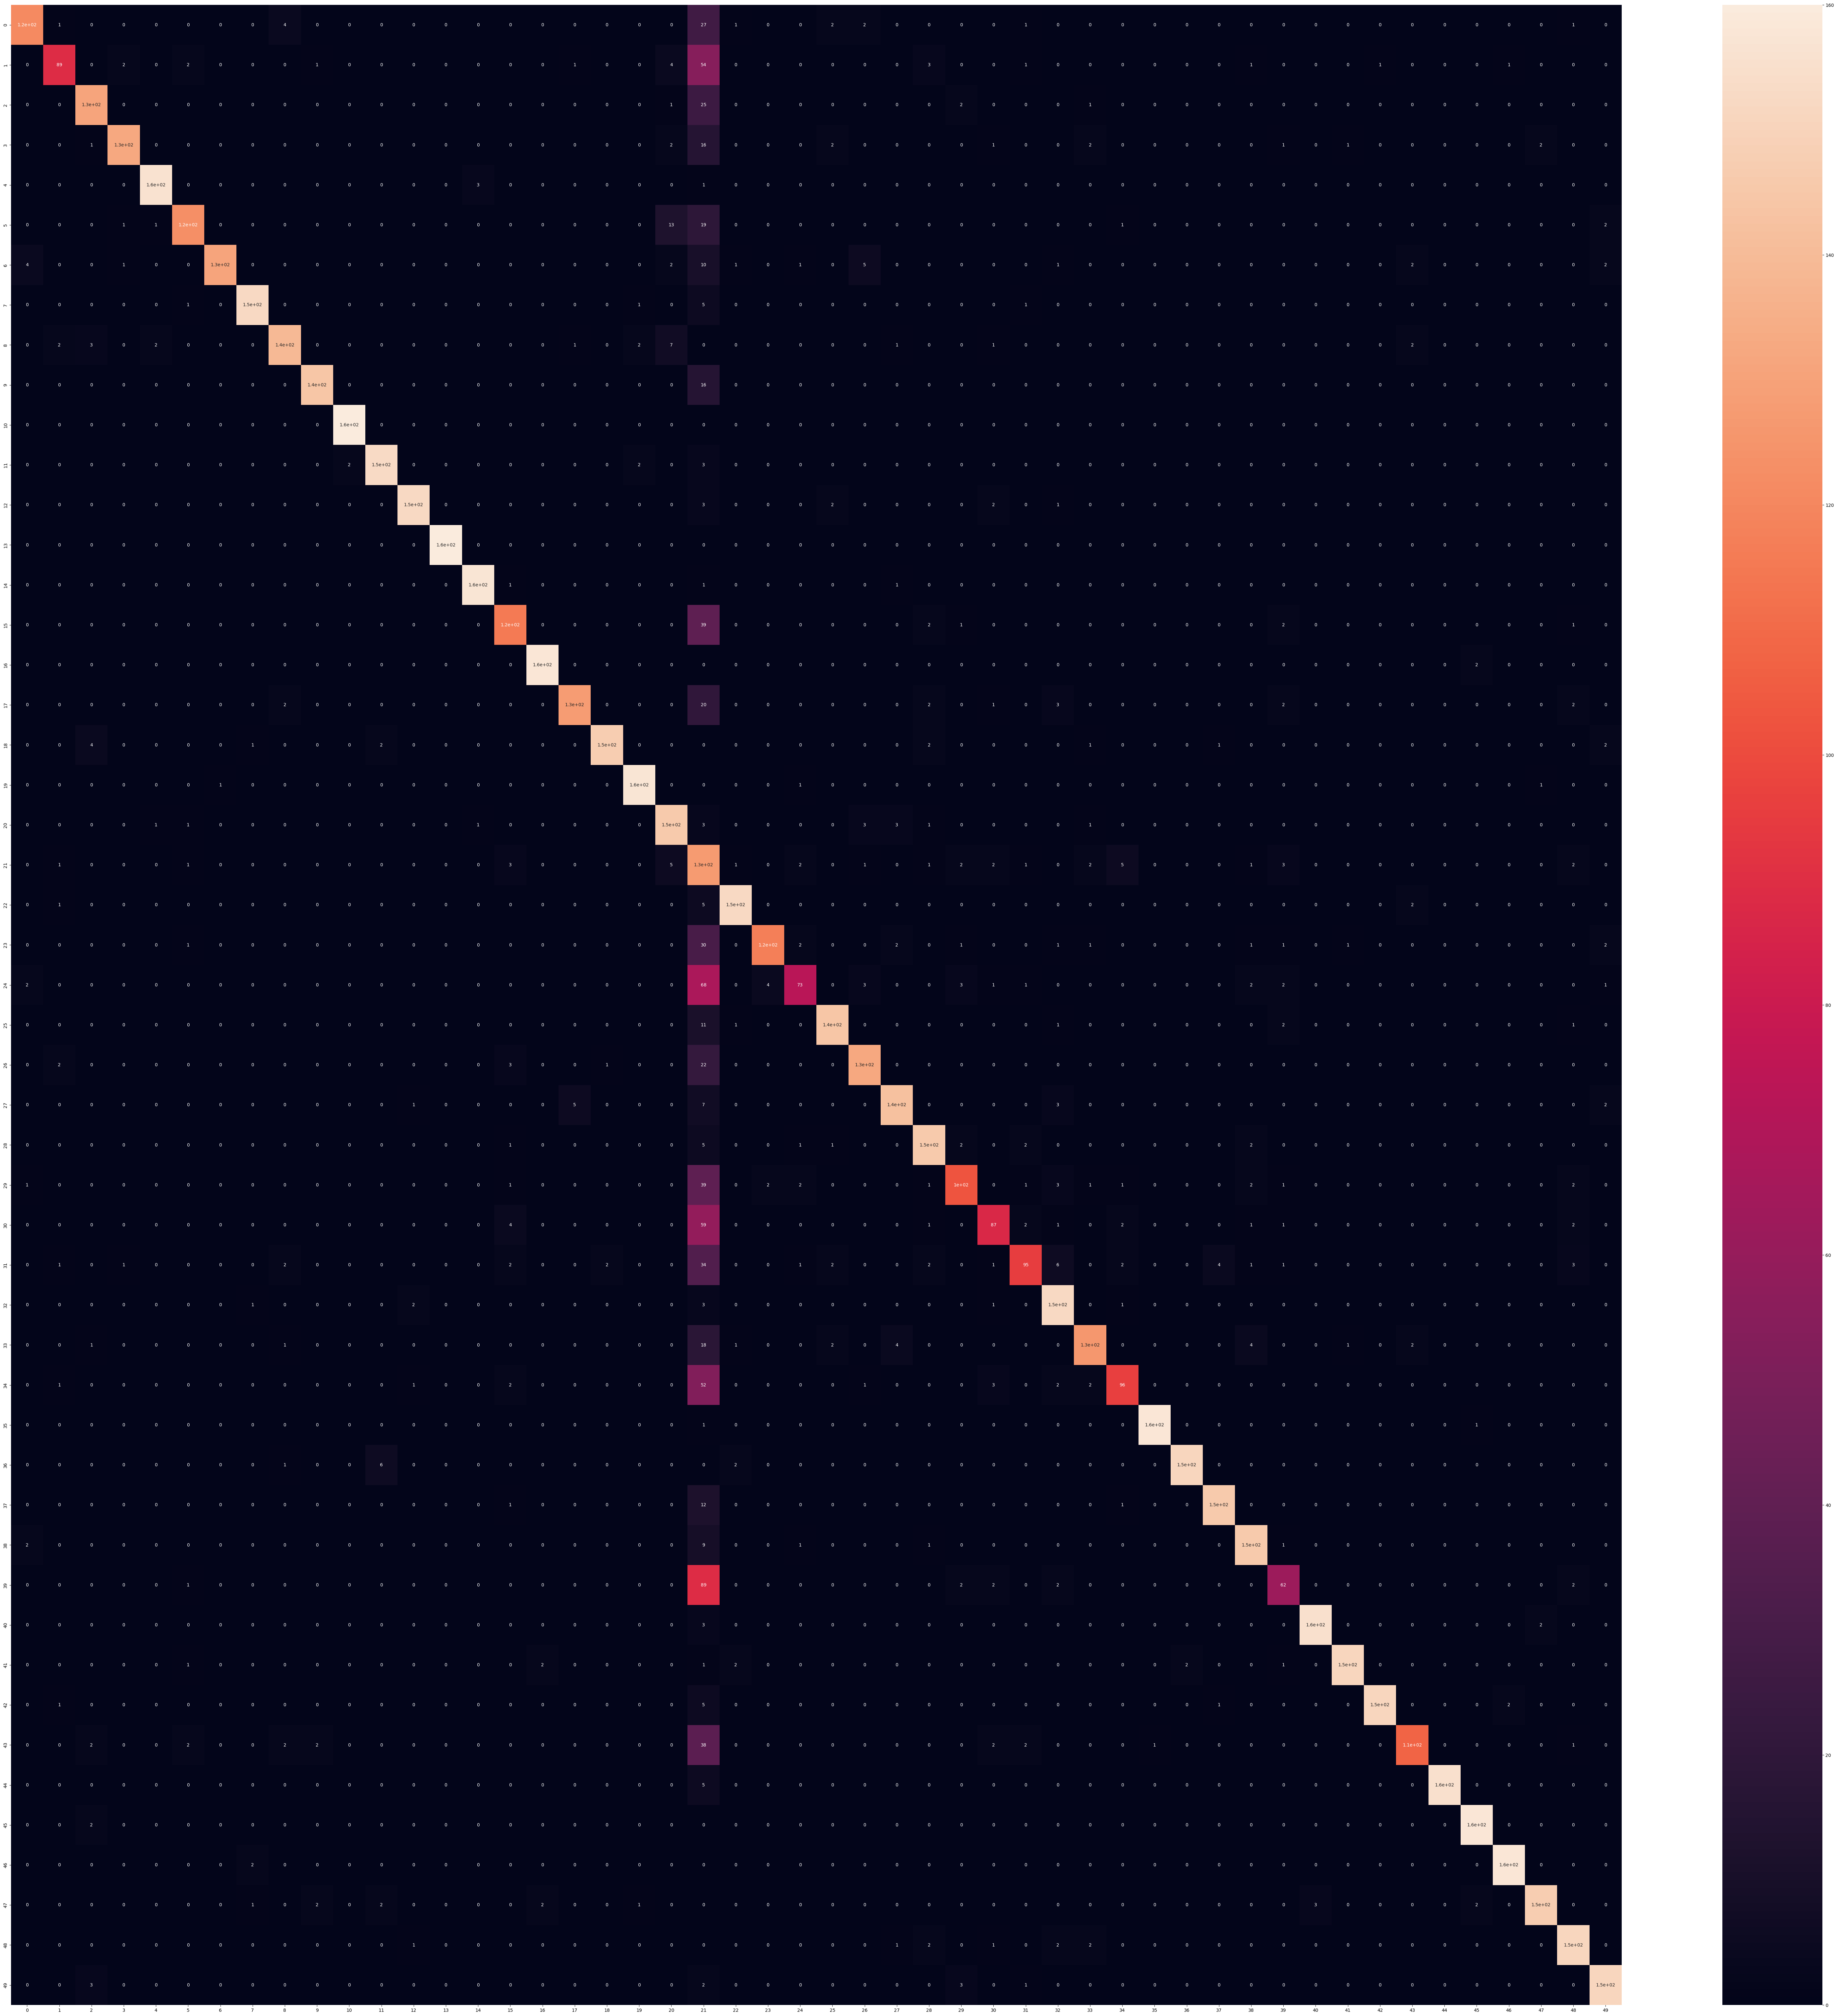

In [423]:
import seaborn as sns
cn_matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize = (80,80))
sns.heatmap(cn_matrix, annot=True)

Видим, что большинство ошибочных предсказания относятся к категории 21, sneezing'у. Чтобы улучшить результаты, нужно отдельно поработать с этой категорией. По-хорошему, наверное, количество сверточных фильтров тоже нужно постепенно увеличивать, двигаясь вглубь нейросети, а не использовать фиксированное количество. Также можно использовать pretrained модели, сделать какой-нибудь ансамбль моделей, попробовать использовать RNN.

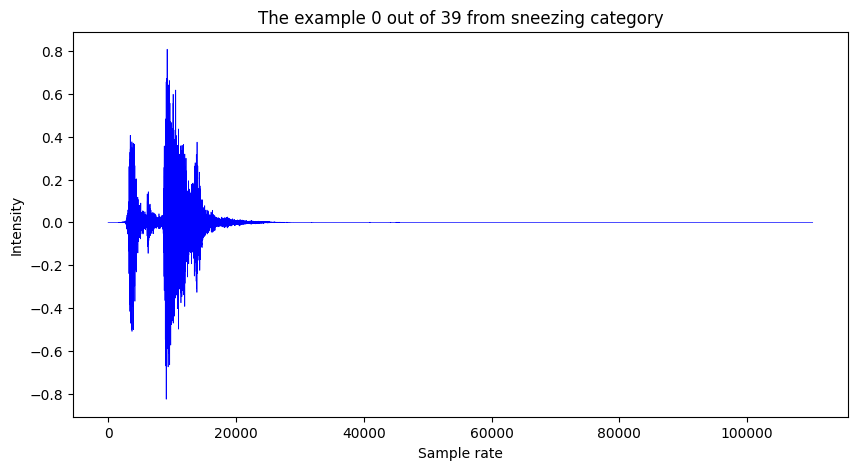

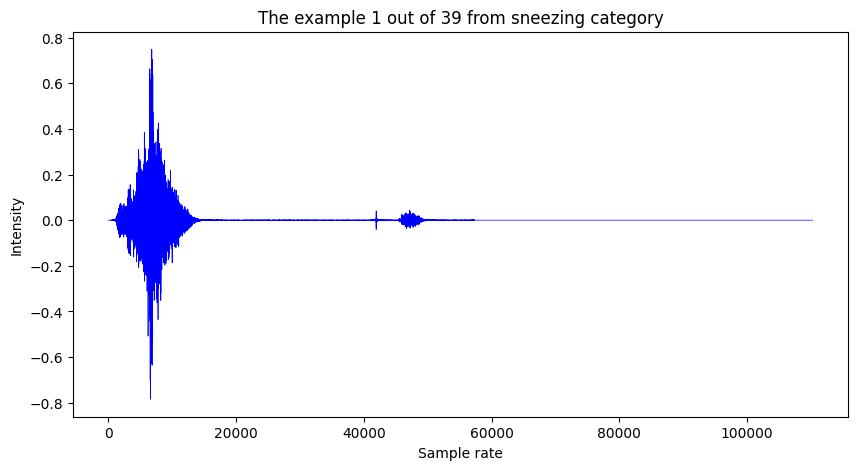

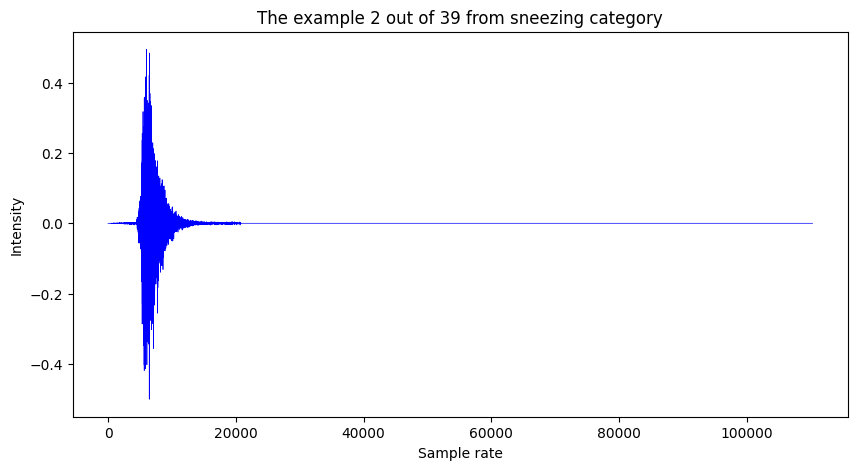

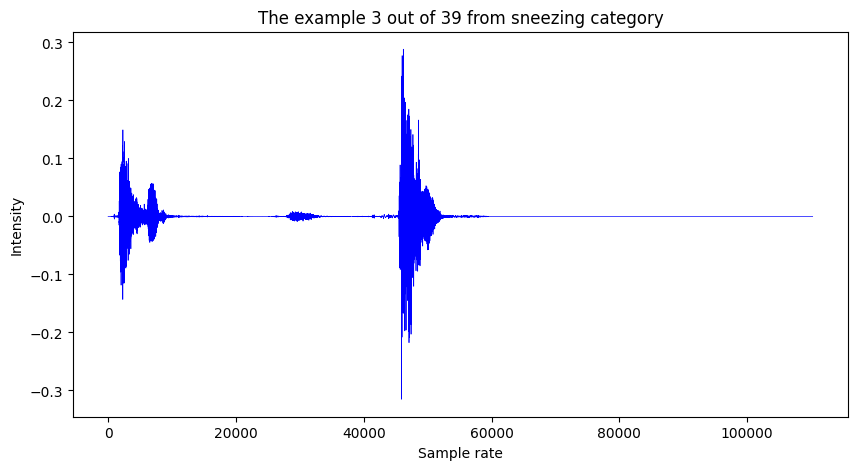

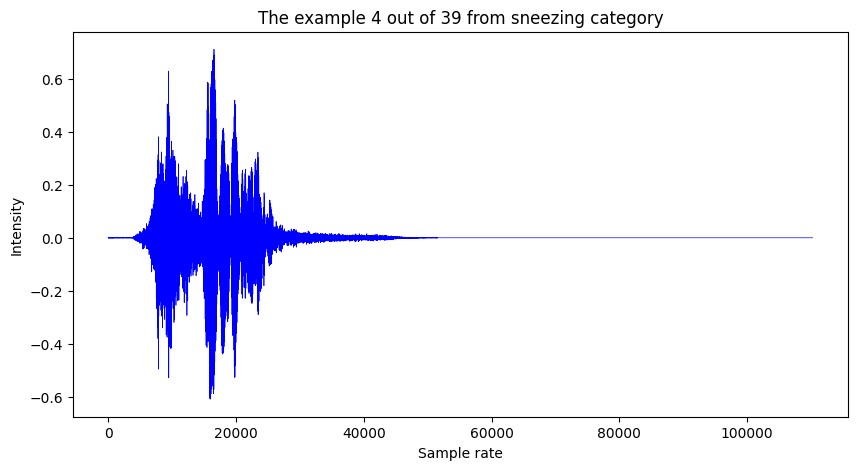

In [433]:
#Cигнал для чиханья
for i in range(5):
    signal_of_category('sneezing', i)